In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 170498071/170498071 [00:08<00:00, 20611036.27it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
batch_size = 4

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

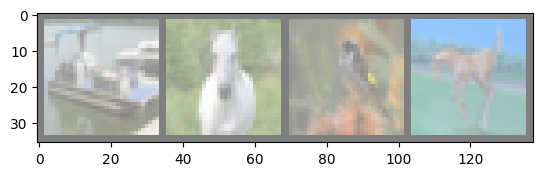

Ship  Horse Bird  Horse


In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

classes = ("plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_dataloader))

imshow(make_grid(images))

print(" ".join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn.functional as F

class CIFARnet(nn.Module):
    def __init__(self):
        super(CIFARnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = CIFARnet().to(device)
net

CIFARnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [8]:
num_epoch = 5

for epoch in range(num_epoch):
    
    running_loss = 0.0
    for i, (inputs, lables) in enumerate(train_dataloader, 0):
        inputs, lables = inputs.to(device), lables.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.288
[1,  4000] loss: 2.058
[1,  6000] loss: 1.910
[1,  8000] loss: 1.771
[1, 10000] loss: 1.663
[1, 12000] loss: 1.613
[2,  2000] loss: 1.515
[2,  4000] loss: 1.505
[2,  6000] loss: 1.461
[2,  8000] loss: 1.429
[2, 10000] loss: 1.422
[2, 12000] loss: 1.392
[3,  2000] loss: 1.348
[3,  4000] loss: 1.323
[3,  6000] loss: 1.319
[3,  8000] loss: 1.309
[3, 10000] loss: 1.317
[3, 12000] loss: 1.290
[4,  2000] loss: 1.231
[4,  4000] loss: 1.243
[4,  6000] loss: 1.233
[4,  8000] loss: 1.242
[4, 10000] loss: 1.233
[4, 12000] loss: 1.218
[5,  2000] loss: 1.149
[5,  4000] loss: 1.139
[5,  6000] loss: 1.158
[5,  8000] loss: 1.183
[5, 10000] loss: 1.154
[5, 12000] loss: 1.178
Finished Training


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move both images and labels to the same device
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [20]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
    
        outputs = net(images)
        
        _,predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 66.9 %
Accuracy for class: Car   is 77.3 %
Accuracy for class: Bird  is 32.7 %
Accuracy for class: Cat   is 47.8 %
Accuracy for class: Deer  is 49.7 %
Accuracy for class: Dog   is 36.0 %
Accuracy for class: Frog  is 55.3 %
Accuracy for class: Horse is 68.2 %
Accuracy for class: Ship  is 74.4 %
Accuracy for class: Truck is 61.0 %
